In [18]:
!git add C3_NLP_with_RNN.ipynb
!git commit -m "NLP with RNN"
!git push

The file will have its original line endings in your working directory


[master 24e8a17] NLP with RNN
 1 file changed, 41 insertions(+), 22 deletions(-)


To https://github.com/auslei/python.git
   ad6b35b..24e8a17  master -> master


## Creating Training Dataset

In [163]:
import tensorflow as tf
from tensorflow import keras

shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

with open(filepath) as f:
    shakespeare_text = f.read()


In [164]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level = True)
tokenizer.fit_on_texts(shakespeare_text)

In [36]:
a = tokenizer.texts_to_sequences(["this is a test", "abcd"])
b = tokenizer.sequences_to_texts(a)

print(a, b)

print(len(tokenizer.word_index), tokenizer.document_count) #num of uniq chars, totol number of docs

[[3, 7, 6, 8, 1, 6, 8, 1, 5, 1, 3, 2, 8, 3], [5, 22, 19, 13]] ['t h i s   i s   a   t e s t', 'a b c d']
39 1115394


In [22]:
import numpy as np

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1 #subtract one to start for 0 index 

In [23]:
encoded.shape

(1115394,)

In [24]:
## Set training Dataset

train_size = len(encoded) * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

print(train_size)

1003854


In [25]:
## chopping dataset into mulitple windows
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead (window is 101)
dataset = dataset.window(window_length, shift = 1, drop_remainder = True) 
# by default window is non-overlapping, setting shift to 1 the window will be overlapping. The shift maybe fine tuned
# use drop_remainder = True to ensure each window is exactly 101 characters long

In [26]:
# window function create nested dataset (each window is a dataset)
# we will use flat_map to convert them into a flat dataset (no nesting), batched on each window size
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [27]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size) # shuffle with a buffer size of 10000 and batch into minibatches
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])) # generate train and targets (0 - 100, 1 - 101)

In [28]:
#on hot encode
dataset = dataset.map(lambda X_batch, y_batch: (tf.one_hot(X_batch, depth = 39), y_batch))

In [15]:
for d in dataset: print(d[0].shape, d[1].shape);break

(32, 100, 39) (32, 100)


In [ ]:
cp_cb = keras.callbacks.ModelCheckpoint("shakespeare.h5")


model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences = True, input_shape = [None, 39], dropout = 0.2, recurrent_dropout = 0),
    keras.layers.GRU(128, return_sequences = True, input_shape = [None, 39], dropout = 0.2, recurrent_dropout = 0),
    keras.layers.TimeDistributed(keras.layers.Dense(39, activation = 'softmax'))
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
history = model.fit(dataset, epochs = 20, callbacks = [cp_cb])

Epoch 1/20
31368/31368 [==============================] - 549s 17ms/step - loss: 1.7187
Epoch 2/20
31368/31368 [==============================] - 543s 17ms/step - loss: 1.5478
Epoch 3/20
31368/31368 [==============================] - 540s 17ms/step - loss: 1.5244
Epoch 4/20
31368/31368 [==============================] - 541s 17ms/step - loss: 1.5121
Epoch 5/20
31368/31368 [==============================] - 540s 17ms/step - loss: 1.5042
Epoch 6/20
 4349/31368 [===>..........................] - ETA: 7:48 - loss: 1.5465

The requirements to use the cuDNN implementation are:

1. activation == tanh
2. recurrent_activation == sigmoid
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. reset_after is True
7. Inputs, if use masking, are strictly right-padded.
8. Eager execution is enabled in the outermost context.

In [ ]:
model.save('shakespeare.h5')

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(history.history)

In [ ]:
history = m.fit(dataset, epochs = 20, callbacks = [cp_cb])

<AxesSubplot:>

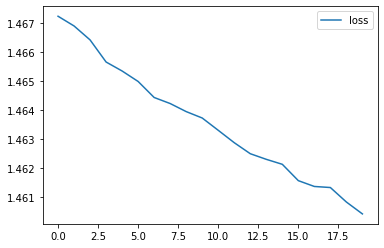

In [33]:
df.plot()

## Using the Char-RNN model

In [165]:
#firstly load the model
m = tf.keras.models.load_model('shakespeare.h5')


# tokenise and onehot the input string.
def preprocess(string):
    return [tf.one_hot(np.array(tokenizer.texts_to_sequences(string))- 1, depth = 39)]

# generate input
t = preprocess("how are yo")

In [168]:
# preduct the character.
pred = m.predict(t)

In [169]:
tokenizer.sequences_to_texts(pred.argmax(axis = -1) + 1)[-1]

'u'

In [154]:
def next_char(text, temperature = 1):
    X_new = preprocess([text])
    y_proba = m.predict(X_new)[0, -1, :] # last preducted timestep
    #print(y_proba.shape)
    rescaled_logits = tf.math.log(y_proba) / temperature #see softmax function below 
    #print(rescaled_logits)
    char_id = tf.random.categorical([rescaled_logits], num_samples = 1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

def complete_text(text, n_chars = 50, temperature = 1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [155]:
print(complete_text('s', temperature=1))

st i bear mine offente. who content you?

baptista:
no! why get him hear: if i will slop her wills and frinke
like a love to go me all in all alone.
i will, your gods's honour at thy other from good foolders.

hortensio:
my lord, i know with her thus first's farther,
are all and pleasant slater boat on poon.
but toat you beloved in pedua! madam
gremio, i keep, but now i know my bold,
and came i me about you woodcan gire;
stend me, is't grubio crankly ears, at instrucente?
unwortens most but whom 


In [144]:
samples = tf.random.categorical(tf.math.log([[0.5, 0.5]]), 5)

In [170]:
def softmax(t):
    return np.exp(t) / np.sum(np.exp(t))

softmax([1,2,3,4,5])


array([0.01165623, 0.03168492, 0.08612854, 0.23412166, 0.63640865])

## Stateful Model

The model before is stateless, ie. at timestep 0, the value is reset to 0. To retain the state, which will help with long term patterns. We will use stateful model, where the final state is preserved.

To do that, it will not make sense to create overlapping windows as before (step = 1) but consequtive windows

In [ ]:
dataset = tf.data